## Überblick Datensatz

In [1]:
import pandas as pd
import numpy as np
import os
import sweetviz as sv
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

### Settings

In [2]:
CREATE_REPORT = False

In [3]:
TEMP_PATH=os.path.join("temp")

In [4]:
PATH_RESEARCH = os.path.join ("input", "research_dataset.csv")

In [5]:
research_df = pd.read_csv(os.path.join(PATH_RESEARCH))

### Überblick

In [6]:
research_df.sample(10)

,sales_calls,interactions,economy,last_upgrade,discount,monthly_usage,ad_spend,bugs_reported,did_renew
1973,1.0,1.0,0.767839,11.445045,0.238496,0.177529,0.173749,0.0,1
8872,1.0,1.0,0.330450,19.716330,0.059828,0.601333,0.569968,0.0,1
3007,0.0,0.0,0.097121,11.527038,0.347345,0.586677,0.579821,1.0,0
166,0.0,0.0,0.052594,16.564880,0.146250,0.595012,0.543459,0.0,1
402,0.0,0.0,0.549278,7.229999,0.214745,0.384014,0.360446,0.0,0
8499,0.0,0.0,0.455523,6.079297,0.344175,0.147237,0.139871,1.0,0
8800,3.0,4.0,0.019418,18.340614,0.309332,0.586250,0.553153,0.0,0
1028,4.0,4.0,0.824815,7.107270,0.305048,0.638884,0.599314,1.0,1
7410,3.0,3.0,0.539627,6.476009,0.189164,0.923516,0.843454,1.0,1
4675,2.0,2.0,0.782446,11.727603,0.294760,0.781094,0.714722,1.0,1


In [7]:
research_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sales_calls    10000 non-null  float64
 1   interactions   10000 non-null  float64
 2   economy        10000 non-null  float64
 3   last_upgrade   10000 non-null  float64
 4   discount       10000 non-null  float64
 5   monthly_usage  10000 non-null  float64
 6   ad_spend       10000 non-null  float64
 7   bugs_reported  10000 non-null  float64
 8   did_renew      10000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 703.2 KB


In [8]:
research_df.shape

(10000, 9)

In [9]:
#research_df.describe()

### Missing Values

In [10]:
research_df[research_df.duplicated()==True]

,sales_calls,interactions,economy,last_upgrade,discount,monthly_usage,ad_spend,bugs_reported,did_renew


In [11]:
research_df.isnull().sum()

sales_calls      0
interactions     0
economy          0
last_upgrade     0
discount         0
monthly_usage    0
ad_spend         0
bugs_reported    0
did_renew        0
dtype: int64

### Profiling Report

In [12]:
if CREATE_REPORT:
    ges_research = sv.analyze(research_df)
    ges_research.show_html(os.path.join(TEMP_PATH, 'ges_research.html'))

* discount wird nach Gefühl vergeben, wenn die Mitarbeiter denken, die Kunden würden sonst abspringen, aber mit discount ggf überredet werden können
* monthly_usage: intensität in der die Software genutzt wird pro Monat, normalisiert
* bugs_reported: engagement, je mehr die Software dem Kunden wert ist, desto eher werden bugs reported
* did_renew: relativ viele Kunden erneuern den Vertrag nicht

### Zusammenhänge

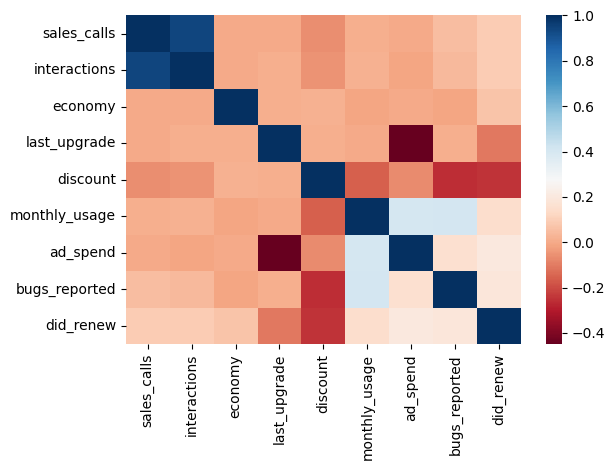

In [13]:
sns.heatmap(research_df.corr().round(2), cmap="RdBu")
plt.tight_layout()

In [14]:
research_df["interactions"].value_counts()

interactions
2.0    2544
3.0    2419
1.0    2229
4.0    1500
0.0    1038
5.0     250
6.0      16
7.0       4
Name: count, dtype: int64

In [15]:
rowSel = research_df["interactions"] == 0
research_df.loc[rowSel, "did_renew"].mean()

0.23892100192678228

In [16]:
research_df.loc[~rowSel, "did_renew"].mean()

0.31209551439410843

<Axes: xlabel='did_renew'>

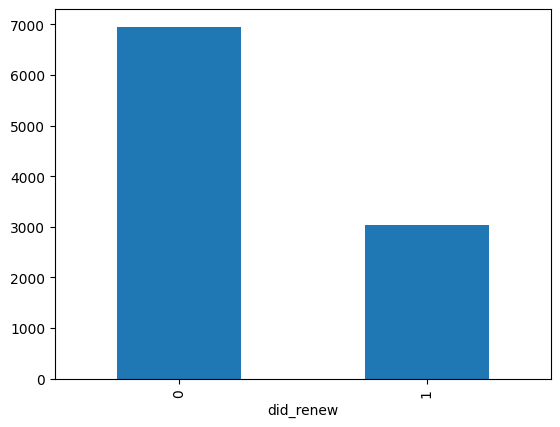

In [17]:
x = research_df["did_renew"].value_counts()
x.plot.bar()

<Axes: xlabel='did_renew', ylabel='Count'>

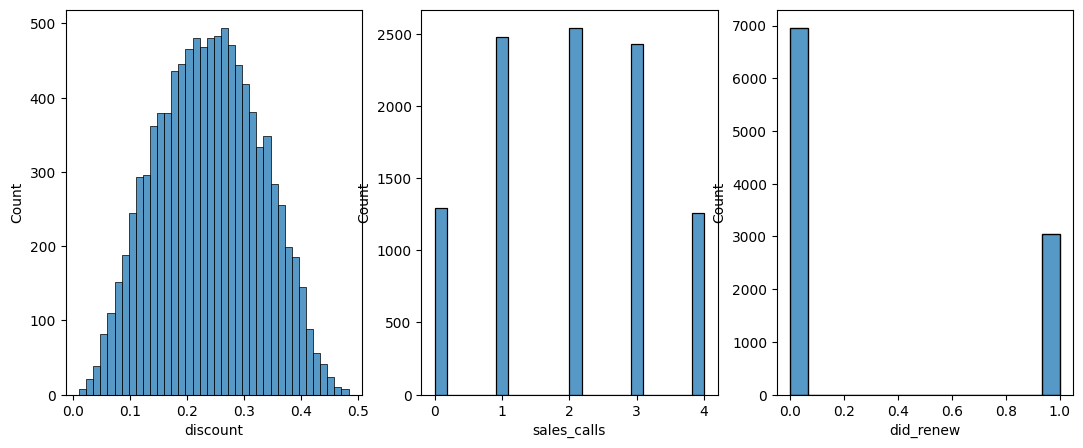

In [18]:
fig, ax = plt.subplots(1, 3, figsize= [13, 5])
sns.histplot(data=research_df, x = "discount", ax = ax[0])
sns.histplot(data=research_df, x = "sales_calls", ax = ax[1])
sns.histplot(data=research_df, x = "did_renew", ax = ax[2])

In [19]:
pd.crosstab(research_df["sales_calls"], research_df["interactions"])

interactions,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
sales_calls,,,,,,,,
0.0,1038,231,23,1,0,0,0,0
1.0,0,1998,432,41,7,0,0,0
2.0,0,0,2089,411,39,4,0,0
3.0,0,0,0,1966,412,50,0,1
4.0,0,0,0,0,1042,196,16,3


In [20]:
table = pd.pivot_table(data=research_df, index="sales_calls", values="did_renew", aggfunc="mean")
#did renew wird hier als prozent angegeben
table

,did_renew
sales_calls,
0.0,0.238979
1.0,0.265133
2.0,0.309477
3.0,0.337999
4.0,0.374702


<Axes: xlabel='sales_calls'>

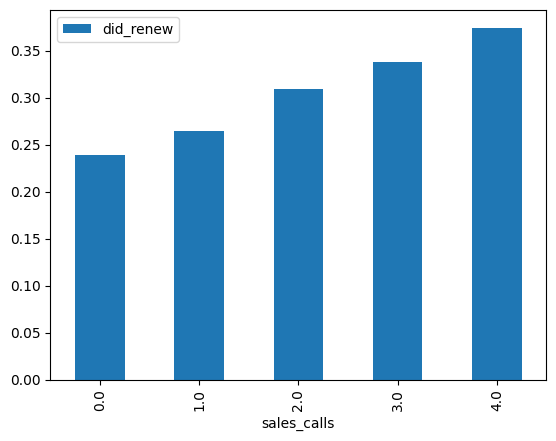

In [21]:
table.plot.bar()
#je mehr anrufe desto höher die Rate der Verlängerung...

### statsmodels

In [22]:
m = smf.logit("did_renew ~sales_calls", data = research_df).fit()
print (m.summary())

Optimization terminated successfully.
         Current function value: 0.610310
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              did_renew   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Fri, 22 Nov 2024   Pseudo R-squ.:                0.007027
Time:                        15:42:30   Log-Likelihood:                -6103.1
converged:                       True   LL-Null:                       -6146.3
Covariance Type:            nonrobust   LLR p-value:                 1.488e-20
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.1622      0.043    -26.936      0.000      -1.247      -1.078
sales_calls     0.1651    

In [23]:
m = smf.logit("did_renew ~sales_calls + last_upgrade + economy + discount + monthly_usage", data = research_df).fit()
print (m.summary())

Optimization terminated successfully.
         Current function value: 0.561560
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              did_renew   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Fri, 22 Nov 2024   Pseudo R-squ.:                 0.08634
Time:                        15:42:30   Log-Likelihood:                -5615.6
converged:                       True   LL-Null:                       -6146.3
Covariance Type:            nonrobust   LLR p-value:                3.081e-227
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.2654      0.113     -2.349      0.019      -0.487      -0.044
sales_calls       0.